In [ ]:
import numpy as np
import cv2
from shapely.geometry import Polygon

# Create a simple binary mask as an example (Replace this with your mask)
mask = np.zeros((100, 100), dtype=np.uint8)
mask[30:70, 30:70] = 255

# Find contours in the binary mask
contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Convert contours to shapely polygons
polygons = [Polygon(contour.reshape(-1, 2)) for contour in contours]

print(polygons)


In [1]:
import glob
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import re

mask_dict = {}
npzFiles = glob.glob("/Users/sherryyang/Documents/wiggins-lab/data/0820/xy0/masks/*.png")
for filename in npzFiles:
    img = Image.open(filename)
    img = img.convert('L')
    mask = np.array(img) 

    pattern = r'_t(\d+)'
    match = re.search(pattern, filename)

    if match:
        t_value = match.group(1)
        t_with_prefix = 't' + t_value
    else:
       raise Exception("No match found.")
    
    mask_dict[t_with_prefix] = mask

In [8]:
import cv2
from shapely.geometry import Polygon
from matplotlib.patches import Polygon as pltPolygon

In [ ]:
contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Step 3: Convert contours to Shapely polygons
polygons = [Polygon(contour.reshape(-1, 2)) for contour in contours]

In [152]:
polygons_dict = {}
for key, mask in mask_dict.items():
    frame_dict={}
    for i in range(1,np.max(mask)+1):
        if np.sum(mask == i) > 4:
            cell_mask = mask == i 
            cell_mask = ( cell_mask  * 255).astype(np.uint8)
            contours, _ = cv2.findContours(cell_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            polygons = [Polygon(contour.reshape(-1, 2)) for contour in contours]
            frame_dict[str(i)] = polygons[0]
    
    polygons_dict[key]=frame_dict

In [153]:
polygons_dict

{'t00006': {'6': <POLYGON ((1549 68, 1548 69, 1547 69, 1540 76, 1540 77, 1523 94, 1523 95, 15...>,
  '7': <POLYGON ((781 89, 780 90, 779 90, 778 91, 777 91, 776 92, 775 92, 774 93, 7...>,
  '8': <POLYGON ((1498 118, 1497 119, 1495 119, 1489 125, 1489 126, 1487 128, 1487 ...>,
  '9': <POLYGON ((705 240, 704 241, 701 241, 700 242, 697 242, 696 243, 693 243, 69...>,
  '10': <POLYGON ((650 306, 650 307, 649 308, 649 316, 650 317, 650 318, 651 319, 65...>,
  '12': <POLYGON ((1360 393, 1359 394, 1358 394, 1353 399, 1353 400, 1351 402, 1351 ...>,
  '13': <POLYGON ((544 489, 543 490, 540 490, 539 491, 538 491, 537 492, 536 492, 53...>,
  '14': <POLYGON ((1242 744, 1241 745, 1234 745, 1233 746, 1230 746, 1229 747, 1227 ...>,
  '15': <POLYGON ((1407 1038, 1403 1042, 1403 1044, 1402 1045, 1402 1046, 1401 1047,...>,
  '18': <POLYGON ((566 1253, 565 1254, 564 1254, 561 1257, 561 1258, 560 1259, 560 1...>,
  '19': <POLYGON ((1633 1344, 1633 1345, 1632 1346, 1632 1347, 1631 1348, 1631 1389,...>,
  '2

In [154]:
sorted_dict = {k: polygons_dict[k] for k in sorted(polygons_dict)}

In [170]:
import itertools
import networkx as nx
G = nx.Graph()

sorted_key = sorted(polygons_dict)

for i in range(len(sorted_key ) - 1):
    t0 = sorted(polygons_dict)[i]
    t1 = sorted(polygons_dict)[i+1]
    cell_dict_t0 = polygons_dict[t0]
    cell_dict_t1 = polygons_dict[t1]
    for cellt0, polygont0 in cell_dict_t0.items():
        for cellt1, polygont1 in cell_dict_t1.items():
            intersection = polygont0.intersection(polygont1)
            union = polygont0.union(polygont1)
            shortest_distance = polygont0.distance(polygont1)
            distance_cost =  -1.0 if shortest_distance == 0 else -1.0 / shortest_distance
            IOU = intersection.area * 1.0 / union.area
            cost = -1 * IOU * 100 + distance_cost
            G.add_edge(t0 + "_" + cellt0, t1 + "_" + cellt1, weight=cost)

In [171]:
cell_dict_t1 = polygons_dict['t00001']
for cell in cell_dict_t1:
    G.add_edge('Source', 't00001' + "_" + cell, weight=-100000)

In [172]:
mst = nx.minimum_spanning_tree(G, algorithm='kruskal')

# Print the edges in the minimum spanning tree
for u, v, data in mst.edges(data=True):
    print(f"{u} -- {v}: {data['weight']}")

t00001_2 -- Source: -100000
t00001_2 -- t00002_2: -84.95802098950524
t00002_2 -- t00003_2: -87.50153075424436
t00002_3 -- t00003_3: -90.55922865013774
t00002_3 -- t00001_3: -90.52352767090855
t00002_4 -- t00003_4: -91.30328919265271
t00002_4 -- t00001_4: -89.78760255241568
t00002_5 -- t00003_5: -90.42324446767729
t00002_5 -- t00001_5: -88.62385492615442
t00002_6 -- t00003_6: -88.19253604749788
t00002_6 -- t00001_6: -86.47982676088444
t00002_9 -- t00003_8: -92.41014365288773
t00002_9 -- t00001_8: -89.68974042027195
t00002_10 -- t00003_9: -88.97709923664122
t00002_10 -- t00001_9: -88.4885004599816
t00002_11 -- t00001_10: -89.79897785349233
t00002_11 -- t00003_10: -88.94801102796377
t00002_12 -- t00003_11: -91.20187099950763
t00002_12 -- t00001_11: -86.96858638743456
t00002_15 -- t00003_14: -90.77547078705939
t00002_15 -- t00001_14: -89.18099076843063
t00002_16 -- t00003_15: -89.8847164851671
t00002_16 -- t00001_15: -87.63951120162933
t00002_17 -- t00003_16: -92.91321499013807
t00002_17 -

In [173]:
pos = {}

for key, value in polygons_dict.items():
    count = len(value)
    pattern = r't(\d+)'
    match = re.search(pattern, key)
    t_value = int(match.group(1))
    
    start_loc = 0
    for cell_name in value:
        pos[key+'_'+cell_name] = (start_loc, -1 * t_value)
        start_loc += 1.0 / count


In [174]:
pos["Source"] = (0.5, 0)

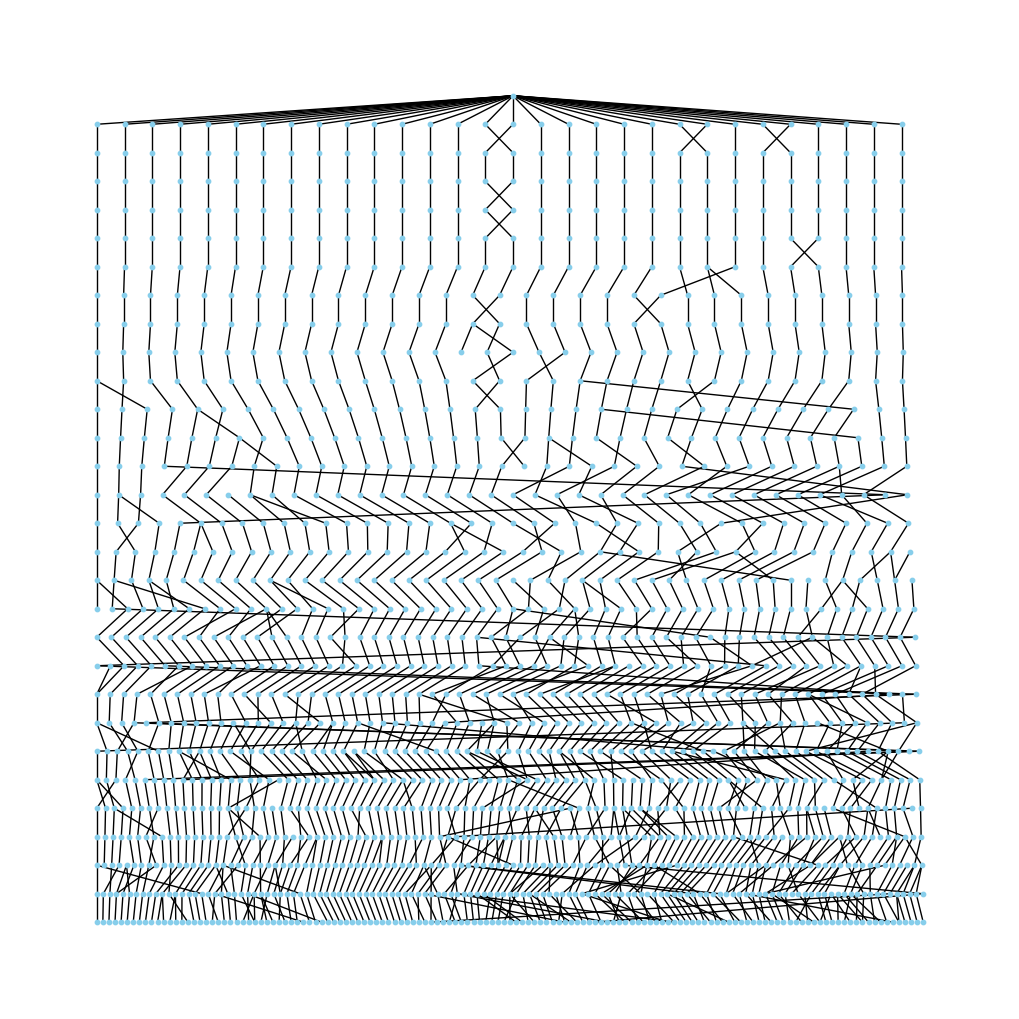

In [175]:
plt.figure(figsize=(10, 10))
nx.draw(mst, pos, with_labels=False, font_weight='bold', node_size=10, node_color='skyblue', font_size=10)
plt.show()

In [161]:
# Print the edges in the minimum spanning tree
for u, v, data in mst.edges(data=True):
    print(f"{u} -- {v}: {data['weight']}")
    if u > v:
        temp = u
        u = v
        v = temp
    

t00001_2 -- Source: -100000
t00001_2 -- t00002_2: -83.95802098950524
t00002_2 -- t00003_2: -86.50153075424436
t00002_3 -- t00003_3: -89.55922865013774
t00002_3 -- t00001_3: -89.52352767090855
t00002_4 -- t00003_4: -90.30328919265271
t00002_4 -- t00001_4: -88.78760255241568
t00002_5 -- t00003_5: -89.42324446767729
t00002_5 -- t00001_5: -87.62385492615442
t00002_6 -- t00003_6: -87.19253604749788
t00002_6 -- t00001_6: -85.47982676088444
t00002_9 -- t00003_8: -91.41014365288773
t00002_9 -- t00001_8: -88.68974042027195
t00002_10 -- t00003_9: -87.97709923664122
t00002_10 -- t00001_9: -87.4885004599816
t00002_11 -- t00001_10: -88.79897785349233
t00002_11 -- t00003_10: -87.94801102796377
t00002_12 -- t00003_11: -90.20187099950763
t00002_12 -- t00001_11: -85.96858638743456
t00002_15 -- t00003_14: -89.77547078705939
t00002_15 -- t00001_14: -88.18099076843063
t00002_16 -- t00003_15: -88.8847164851671
t00002_16 -- t00001_15: -86.63951120162933
t00002_17 -- t00003_16: -91.91321499013807
t00002_17 -

In [120]:
import pandas as pd
different_tracker_matches = pd.read_csv('/Users/sherryyang/Documents/wiggins-lab/data/trackers_matchs_index.csv')

In [121]:
different_tracker_matches

,manuel,trackmate,supperSegger
0,t1-t2,0.5,t00001
1,t2-t3,1.5,t00002
2,t3-t4,2.5,t00003
3,t4-t5,3.5,t00004
4,t5-t6,4.5,t00005
5,t6-t7,5.5,t00006
6,t7-t8,6.5,t00007
7,t8-t9,7.5,t00008
8,t9-t10,8.5,t00009
9,t10-t11,9.5,t00010


In [176]:
graph_linked_dict = {}
for u, v, data in mst.edges(data=True):
    if u > v:
        temp = u
        u = v
        v = temp
    
    if u == "Source":
        continue
    
    cell0 = u.split('_')
    cell1 = v.split('_')

    if cell0[0] not in graph_linked_dict:
        graph_linked_dict[cell0[0]] = {}

    if int(cell0[1]) in graph_linked_dict[cell0[0]]:
        graph_linked_dict[cell0[0]][int(cell0[1])].add(int(cell1[1]))
    else:
        graph_linked_dict[cell0[0]][int(cell0[1])] = {int(cell1[1])}



In [163]:
excel_path = "/Users/sherryyang/Documents/wiggins-lab/data/manuelly_linked.xlsx"

excel_file = pd.ExcelFile(excel_path)
sheet_names = excel_file.sheet_names

manual_link_master_dict = {}
for time_sheet in sheet_names:
        df = excel_file.parse(time_sheet)
        df = df.astype(str)
        columns = df.columns
        
        time_dict = {}
        for index, row in df.iterrows():
            try:
                mother = int(row[columns[0]])
            except ValueError:
                mother = None
            daughter = row[columns[1]].lower()
            if 'x' in daughter:
                cell_list = []
            else:
                cell_list = daughter.split(',')
            time_dict[mother] = {int(x) for x in cell_list}
        
        manual_link_master_dict[time_sheet] = time_dict

In [177]:
for index, matches in different_tracker_matches.iterrows():  
    manuel_dict = manual_link_master_dict[matches['manuel']]
    graph_assignment = graph_linked_dict[matches['supperSegger']]

    total_number = len(manuel_dict)
    graphy_correct_number = 0

    for key, value in manuel_dict.items():
        if  (key in graph_assignment) and (graph_assignment[key]== value):
            graphy_correct_number+=1

    print(graphy_correct_number * 1.0 / total_number)

1.0
1.0
1.0
1.0
1.0
1.0
1.0
0.967741935483871
1.0
1.0
1.0
1.0
0.9459459459459459
1.0
0.975
0.9302325581395349
1.0
0.9814814814814815
0.9473684210526315
0.9836065573770492
0.9516129032258065
0.9701492537313433
0.9146341463414634
0.9540229885057471
0.8631578947368421
0.8921568627450981
0.9017857142857143
0.8870967741935484


In [136]:
graph_linked_dict['t00001']

{0: {0},
 2: {2},
 3: {3},
 4: {4},
 5: {5},
 6: {6},
 8: {9},
 9: {10},
 10: {11},
 11: {12},
 14: {15},
 15: {16},
 16: {17},
 17: {18},
 19: {20},
 22: {23},
 21: {24},
 23: {25},
 24: {26},
 25: {28},
 26: {29},
 27: {30},
 29: {31},
 28: {32},
 30: {33},
 32: {35},
 31: {36},
 33: {37},
 34: {38},
 39: {42}}

In [139]:
np.sum(mask_dict['t00001'] == 41)

1494

In [166]:
polygons_dict['t00001']

{'2': <POLYGON ((1527 91, 1526 92, 1525 92, 1524 93, 1524 94, 1522 96, 1522 97, 15...>,
 '3': <POLYGON ((767 98, 766 99, 764 99, 763 100, 761 100, 760 101, 759 101, 758 1...>,
 '4': <POLYGON ((1487 132, 1483 136, 1483 137, 1481 139, 1481 140, 1480 141, 1480 ...>,
 '5': <POLYGON ((680 249, 679 250, 678 250, 676 252, 675 252, 673 254, 672 254, 66...>,
 '6': <POLYGON ((670 334, 668 336, 668 343, 669 344, 669 345, 670 346, 670 347, 67...>,
 '8': <POLYGON ((1350 414, 1346 418, 1346 419, 1345 420, 1345 421, 1344 422, 1344 ...>,
 '9': <POLYGON ((512 511, 511 512, 510 512, 509 513, 508 513, 503 518, 502 518, 48...>,
 '10': <POLYGON ((1219 751, 1218 752, 1215 752, 1214 753, 1212 753, 1211 754, 1209 ...>,
 '11': <POLYGON ((1403 1052, 1402 1053, 1401 1053, 1400 1054, 1400 1055, 1398 1057,...>,
 '14': <POLYGON ((562 1308, 561 1309, 560 1309, 560 1310, 559 1311, 559 1312, 558 1...>,
 '15': <POLYGON ((1636 1366, 1635 1367, 1634 1367, 1632 1369, 1632 1372, 1631 1373,...>,
 '16': <POLYGON ((650 1392, 

(<matplotlib.patches.PathPatch at 0x306a28d00>,
 <matplotlib.lines.Line2D at 0x301ea9330>)

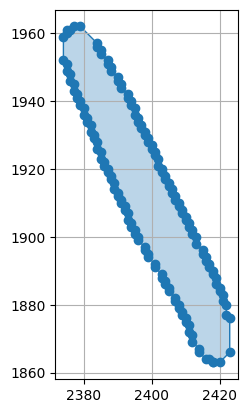

In [167]:
import shapely.plotting
shapely.plotting.plot_polygon(polygons_dict['t00001']['41'])